# Libraries with fixed versions and data loading

In [1]:
# %%capture
# %pip install xgboost==1.6.2
# %pip install shap==0.41.0
# %pip install pandas==1.3.5
# %pip install plotly==5.10.0
# %pip install scikit-learn==1.0.2
# %pip install seaborn

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
# # Enable export of plotly interactivity in html export
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected = True)

To load the data, you can simply put it on Google Drive and read it in a few lines of code (there are multiple other ways to do it).

For speed, we can load only the provided 26 columns (1 target, 1 ID and 24 features).

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
ap_train = pd.read_csv('Data/CSV/application_train.csv',
                    usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])
print(f"Application train dataset shape: {ap_train.shape}")

Application train dataset shape: (307511, 26)


For simplicity, we'll create a AGE (in years) variable from DAYS_BIRTH (in days).

In [6]:
ap_train['AGE'] = -round(ap_train['DAYS_BIRTH']/365)
ap_train.drop(columns='DAYS_BIRTH', inplace=True)

# **[#1] Interesting variables**

In [7]:
ap_train = ap_train[ap_train.CODE_GENDER != "XNA"]

In [8]:
int_cols = ["CODE_GENDER", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "AGE"]

In [9]:
ap_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
OCCUPATION_TYPE                object
EXT_SOURCE_1                  float64
EXT_SOURCE_2                  float64
EXT_SOURCE_3                  float64
AGE                           float64
dtype: objec

In [10]:
ap_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  307507 non-null  int64  
 1   TARGET                      307507 non-null  int64  
 2   NAME_CONTRACT_TYPE          307507 non-null  object 
 3   CODE_GENDER                 307507 non-null  object 
 4   FLAG_OWN_CAR                307507 non-null  object 
 5   FLAG_OWN_REALTY             307507 non-null  object 
 6   CNT_CHILDREN                307507 non-null  int64  
 7   AMT_INCOME_TOTAL            307507 non-null  float64
 8   AMT_CREDIT                  307507 non-null  float64
 9   AMT_ANNUITY                 307495 non-null  float64
 10  AMT_GOODS_PRICE             307229 non-null  float64
 11  NAME_TYPE_SUITE             306215 non-null  object 
 12  NAME_INCOME_TYPE            307507 non-null  object 
 13  NAME_EDUCATION

In [11]:
ap_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,307507.000000,104580.000000,134131.000000,3.068470e+05,246542.000000,307507.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,63815.929208,-4986.131376,-2994.201670,12.061121,0.502129,5.143918e-01,0.510856,43.938736
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,141276.472519,3522.883030,1509.454566,11.944919,0.211063,1.910603e-01,0.194843,11.964030
min,100002.000000,0.00000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-17912.000000,-24672.000000,-7197.000000,0.000000,0.014568,8.173617e-08,0.000527,21.000000
25%,189146.500000,0.00000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-2760.000000,-7479.500000,-4299.000000,5.000000,0.334007,3.924574e-01,0.370650,34.000000
50%,278203.000000,0.00000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-1213.000000,-4504.000000,-3254.000000,9.000000,0.505998,5.659614e-01,0.535276,43.000000
75%,367143.500000,0.00000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-289.000000,-2010.000000,-1720.000000,15.000000,0.675057,6.636171e-01,0.669057,54.000000
max,456255.000000,1.00000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,365243.000000,0.000000,0.000000,91.000000,0.962693,8.549997e-01,0.896010,69.000000


In [12]:
int_cols_con = []
int_cols_cat = []

for col in int_cols:
    if ap_train[col].dtype == object:
        int_cols_cat.append(col)
    else:
        int_cols_con.append(col)

In [13]:
int_cols_con

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE']

In [14]:
int_cols_cat

['CODE_GENDER',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [15]:
df_binned = pd.DataFrame()
df_binned["TARGET"] = ap_train["TARGET"]
for col in int_cols:
    df_binned[col] = ap_train[col]

In [16]:
print(df_binned.shape)

(307507, 9)


In [17]:
def cap_data(dati, col_list):
    for col in col_list:
        print("capping the ",col)
        if (((dati[col].dtype)=='float64') | ((dati[col].dtype)=='int64')):
            percentiles = dati[col].quantile([0.01,0.99]).values
            dati[col][dati[col] <= percentiles[0]] = percentiles[0]
            dati[col][dati[col] >= percentiles[1]] = percentiles[1]
        else:
            dati[col]=dati[col]
    return dati

df_binned=cap_data(df_binned, int_cols_con)

capping the  CNT_CHILDREN
capping the  AMT_INCOME_TOTAL
capping the  AGE



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
df_binned.shape

(307507, 9)

In [19]:
for col in int_cols_con:
    df_binned[col] = pd.cut(df_binned[col], 6, precision=0)

In [20]:
df_binned["CNT_CHILDREN"].describe()

count            307507
unique                4
top       (-0.003, 0.5]
freq             215369
Name: CNT_CHILDREN, dtype: object

In [21]:
df_binned["AMT_INCOME_TOTAL"]

0         (187500.0, 258750.0]
1         (258750.0, 330000.0]
2          (44572.0, 116250.0]
3         (116250.0, 187500.0]
4         (116250.0, 187500.0]
                  ...         
307506    (116250.0, 187500.0]
307507     (44572.0, 116250.0]
307508    (116250.0, 187500.0]
307509    (116250.0, 187500.0]
307510    (116250.0, 187500.0]
Name: AMT_INCOME_TOTAL, Length: 307507, dtype: category
Categories (6, interval[float64, right]): [(44572.0, 116250.0] < (116250.0, 187500.0] < (187500.0, 258750.0] < (258750.0, 330000.0] < (330000.0, 401250.0] < (401250.0, 472500.0]]

In [22]:
df_binned["TARGET"].describe()

count    307507.00000
mean          0.08073
std           0.27242
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max           1.00000
Name: TARGET, dtype: float64

In [23]:
import os

outpath = 'Plots'

# Check whether the specified path exists or not
isExist = os.path.exists(outpath)

if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(outpath)
  print("The new directory is created!")

os.chdir(outpath)

The new directory is created!


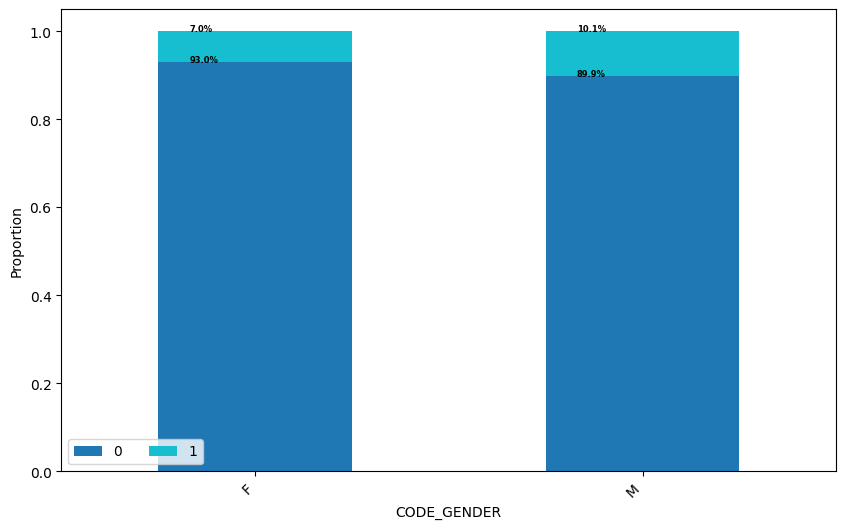

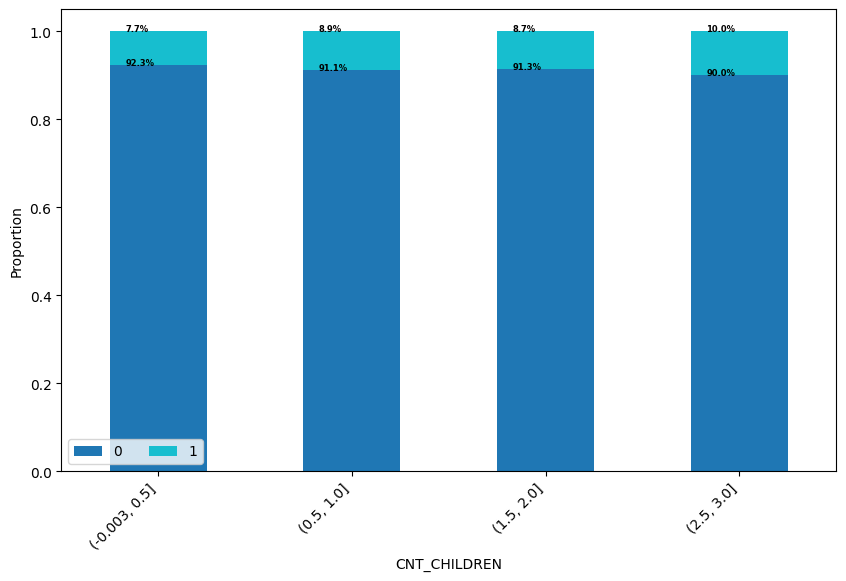

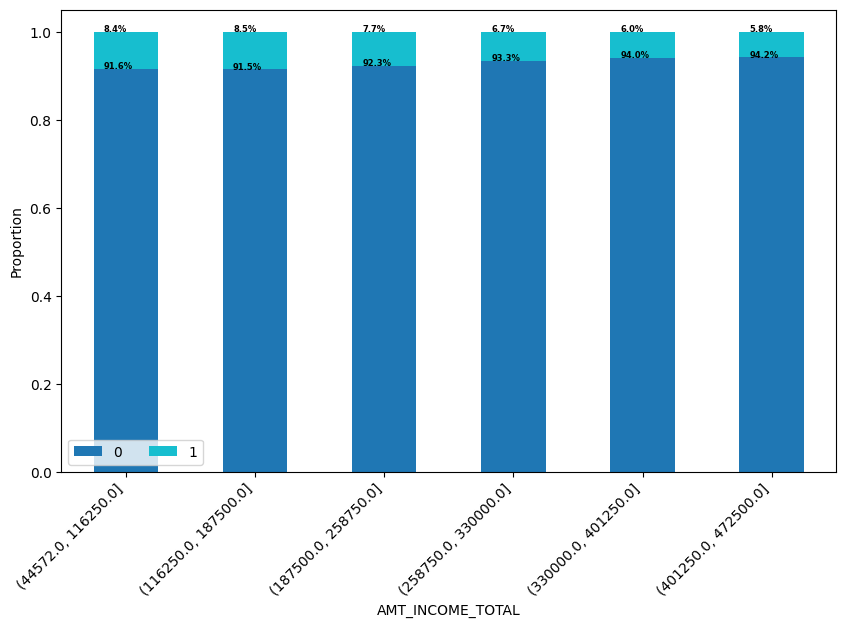

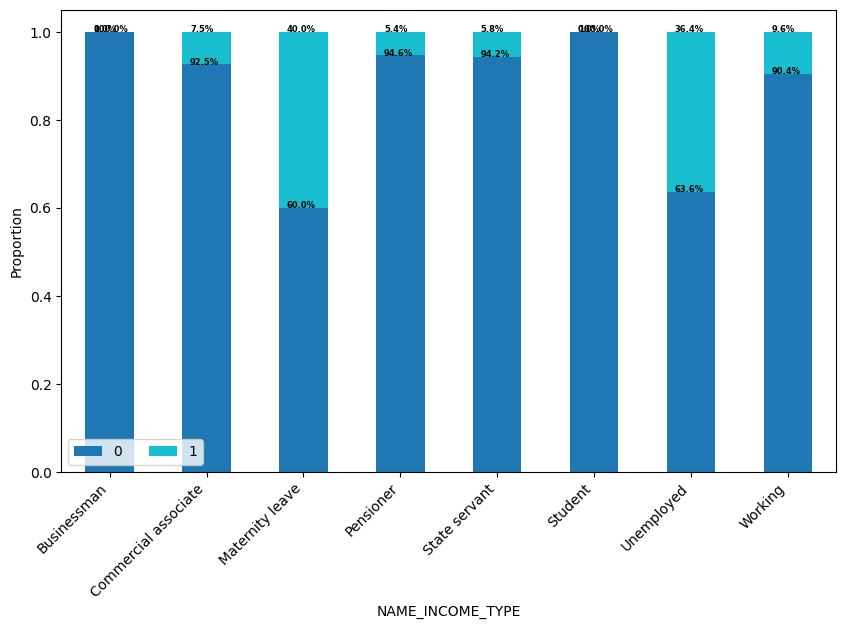

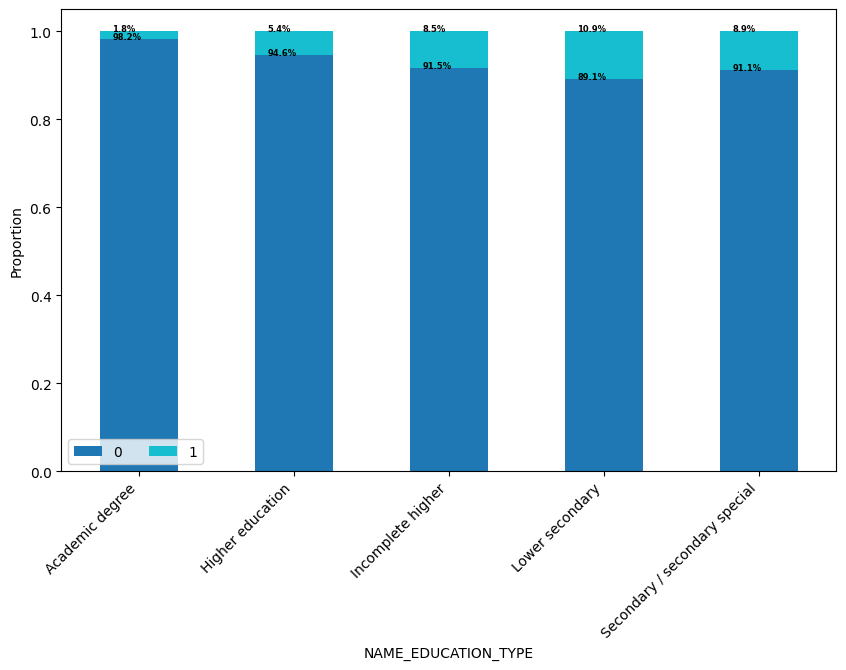

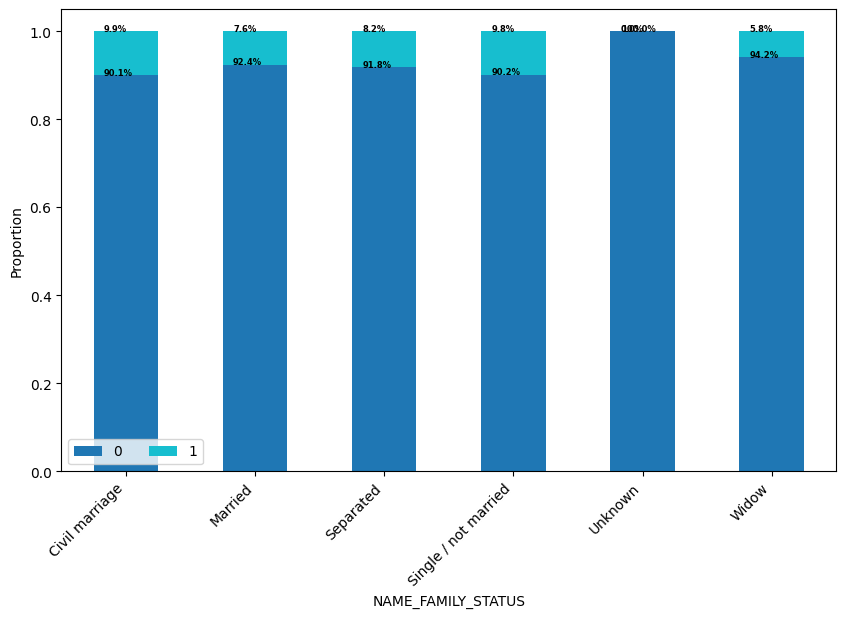

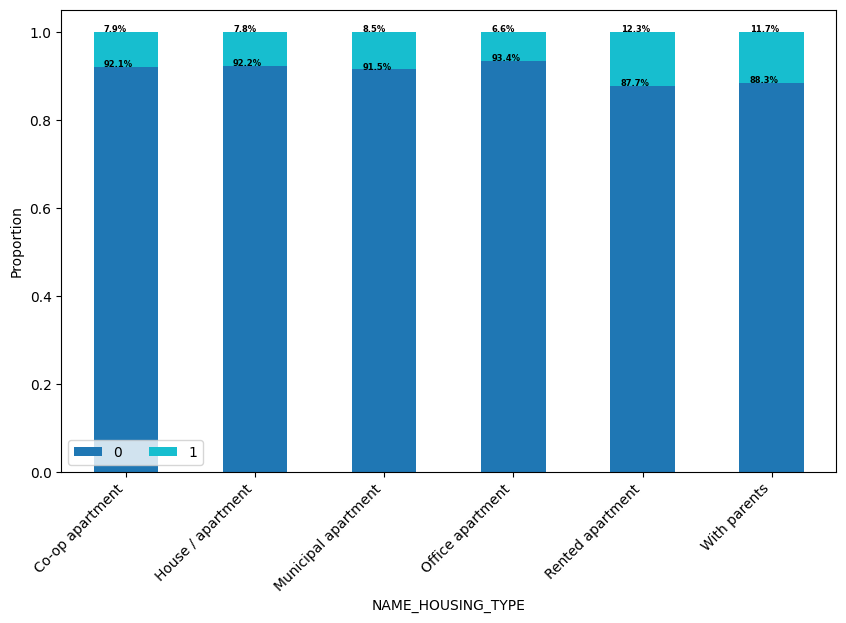

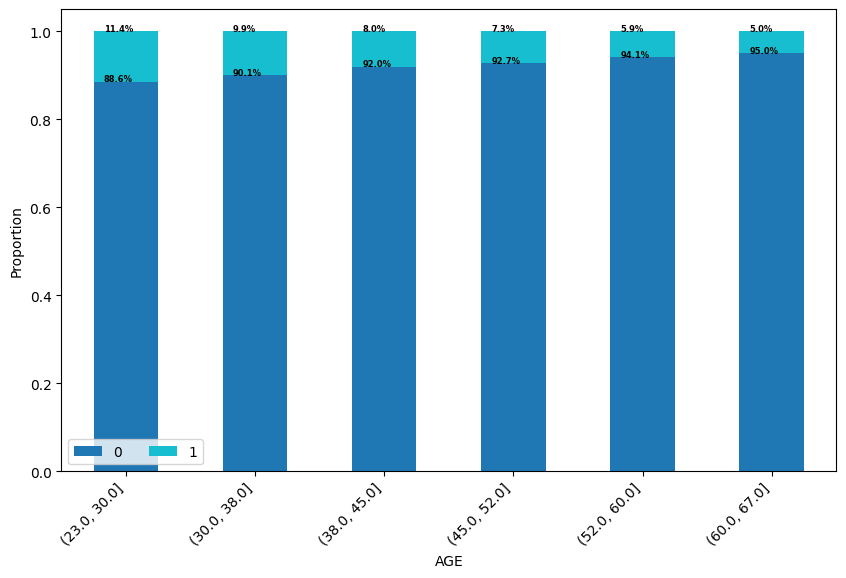

In [24]:
import matplotlib.pyplot as plt



for col in int_cols:
    cross_tab_prop = pd.crosstab(index=df_binned[col],
                            columns=df_binned["TARGET"],
                                normalize="index")
    cross_tab_prop

    cross_tab = pd.crosstab(index=df_binned[col],
                            columns=df_binned["TARGET"])
    cross_tab

    cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

    plt.legend(loc="lower left", ncol=2)
    plt.xlabel(str(col))
    plt.ylabel("Proportion")
    plt.xticks(rotation=45, ha='right')


    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                    cross_tab_prop.loc[x].cumsum()):
                    
            plt.text(x=n - 0.17,
                    y=y_loc,
                    s=f'{np.round(proportion * 100, 1)}%', 
                    color="black",
                    fontsize=6,
                    fontweight="bold")

    plt.savefig(str(col))
    plt.show()

# **[#2] Interesting variables with respect to target**

# Preparing the data

Let's prepare the data for a simple ML model.

First of all, feature encoding.

In [ ]:
ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)
ap_train.drop(columns='CODE_GENDER', inplace=True)

In [ ]:
ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
ap_train[ap_objects] = ap_train[ap_objects].astype('category')

Let's separate the target from the rest of the data

In [ ]:
ap_train_target = ap_train.pop('TARGET')
print(f"Target dataset shape: {ap_train_target.shape}")

Let's split the original dataset in two:

*   80% for the train dataset
*   20% for the test one



In [ ]:
df_train, df_test, df_target_train, df_target_test = train_test_split(
    ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

# Create a basic ML model and scoring on the test set

I'll train a simple XGBoost model (parameters previously chosen with cross-validation).  

In [ ]:
df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), df_target_train, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)

Let's score the test set.

In [ ]:
df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)

What are the risk scores (from 0 to 1) of the first 5 customers in the test set? And what's the overall AUC on the test set?

In [ ]:
xgb_base_test_results[:5]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
metrics.auc(fpr, tpr)

The third customer has a higher risk score (0.796) than the others in the first 5 records.

This simple model has an AUC on the test set around **0.754**, a decent baseline performance.

# **[#3] Evaluating feature importance**

# **[#4] Comparing the model predictions with respect to the original training data**

# **[#5] Comparison of a few cases, changing just 1 or 2 features**

# **[#6] Wrap up: characteristics of the training dataset and how a ML model learns them**

# **[#7] Dropping all our concerns**


# **[#8] A closer look at the performance without features of ethical concern**

# **[#9] Wrapping up again: what happens by just removing the features of concern**

# **[#10] Hints at a possible (but questionable!) solution**